# NER pipeline to detect specimen codes in article text

Use a combination of pattern matching and NER training to extract references to SPECIMEN from article text
1. **Make training data**: extract sentences matching upper/digit pattern to label
2. **Train NER model**: apply labels to train transformer-based model to detect `SPECIMEN` entities
3. **Apply NER model**: extract references to `SPECIMEN` entities in UMMZ Bibliography

## 1. Make training data
Prepare training data from UMMZ Bibliography. Does not require accelerator (GPU).

In [12]:
import pandas as pd
import numpy as np
import re
import glob
import random
from random import sample
import json
import jsonlines
import pysbd
seg = pysbd.Segmenter(language="en", clean=False) # sentence segmenter
import spacy
from spacy.matcher import Matcher # pattern matching

Define rule-based pattern (UPPER, DIGIT) to find sentences to label

In [2]:
nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)
pattern = [{'IS_UPPER': True}, {'IS_DIGIT': True}] # token sequence has uppercase followed by digit
matcher.add("specimen_code", [pattern])

Helper functions for parsing json documents

In [11]:
def json2txt_df(json_file_path):
    """
    Extract body text of json file
    """
    with open(json_file_path, 'r') as f:
        data = json.loads(f.read())
        body_text_df = pd.json_normalize(data["pdf_parse"]["body_text"])
    
    return body_text_df

def df2sentences(df):
    """
    Tokenize and clean sentences
    """
    sentences_text = " ".join(list(df.text)) 
    pattern_brackets = re.compile(r'\(.*?\)')
    sentences_text = re.sub(pattern_brackets, "", sentences_text) 
    sentences = seg.segment(sentences_text) 
    sentences = [re.sub(r"^\W+", "", sentence) for sentence in sentences] 
    sentences = [re.sub(r"\s+", " ", sentence) for sentence in sentences]
    return sentences

def prep_data(json_file_path, ref_id):
    """
    Return sentence lists for matches
    """
    body_text_df = json2txt_df(json_file_path)
    sentences = df2sentences(body_text_df)
    candidates = []
    for sentence in sentences:
        doc = nlp(sentence)
        matches = matcher(doc)
        if len(matches) > 0:
            sentence_dict = {"text":sentence,
                             "meta":{"ref_id":str(ref_id)}}
            candidates.append(sentence_dict)    
    return candidates

Project directories
- Articles in UMMZ Bibliography (646 papers, 45% as of May 17, 2022)

In [4]:
papers_path = "/nfs/turbo/isr-slafia/specimen/may_zotero_ummz_out/"
save_path = "/nfs/turbo/isr-slafia/specimen/may_zotero_ummz_sents/"

In [5]:
print(f"Searching {len(glob.glob(papers_path+'/*.json'))} papers for specimen codes")

Searching 646 papers for specimen codes


Check each sentence for pattern. If it matches, get the sentence and file name. 

In [6]:
%%time

bib_files = sorted(glob.glob(papers_path+'/*.json'))

for bib_file in bib_files:
    ref_id = bib_file.split("/")[-1].split("-")[0]
    try: 
        sentence_dicts_list = prep_data(bib_file, ref_id)
        print(ref_id) # show file name for the match
        with jsonlines.open(save_path+'/ummz_pattern_matching.jsonl', 'a') as writer:
            writer.write_all(sentence_dicts_list)
    except:
        0

0003
0006
0006
0006
058.009.0206.json
1
1
1
1
1
1
1
1
1
1
10
10
10.1.1.363.5201.json
10.1.1.379.5610.json
10.1.1.81.3624.json
10.1515_mamm.2001.65.2.205.json
10.1515_mamm.2010.017.json
10.2478_s11686
11
11.EvaluatingtheMitten
12
13
13
1362394.json
1362713.json
1362845.json
1363568.json
1373273.json
1373370.json
1373530.json
1373715.json
1373764.json
1373833.json
1373867.json
1373881.json
1373910.json
1373931.json
1373992.json
1374124.json
1374454.json
1374472.json
1374527.json
1377277.json
1377569.json
14
14
14
14
14
15
15
15
15103.json
16
17
17
17
17
1929048.json
1929088.json
1929272.json
1930930.json
1932409.json
2
2
2
2
2
2
2
2
2
2
20
2000_C_merriami.json
2007
2007
2007
2010_Chinese.Sci.Bull._Guo
2018_Book_PrimateLifeHistoriesSexRolesAn.json
2019_Book_EmergingResearchInComputingInf.json
2158
2158
2420288.json
2456815.json
3
31295010062502
31295010062502.json
33
334.1.json
351.1.json
3534095.json
3535061.json
3720.2.json
3740.2.json
3769.2.json
3796432.json
3802.1.json
3817.1.json
39

Export matching sentences and metadata (source file name) for labeling offline
* It took 2 hours to label 1,010/3,953 sentences on a local machine
* Labeling rules:
    * Accept (positive): entity is a specimen code
    * Accept (negative): entity is not a specimen code
    * Ignored: sentence is malformed, not enough context for training
* Sources of confusion:
    * software, sequencing techniques (ABI3700), state/postal codes, p values (P2), null hypothesis (H0), compounds (CO2), grant numbers, coordinate reference system (WGS84), dates (AD1200), legislation (HB117), metadata (ISO2788)
    * spans or compound codes (TMM 45947-506 and -510)
    * tokenization and sentence fragments from scientific notation
    * unlikely documents in bibliography (Advances in Computation… President’s Comments and Report…)
* Approach: [Manual NER in Prodigy](https://prodi.gy/docs/recipes#ner-manual) labeling using a pattern template
    * Pattern template: {"label": "SPECIMEN", "pattern": [{"is_upper": true}, {"is_digit": true}]}
    * Prodigy recipe: prodigy ner.manual ummz_v1 en_core_web_sm ./ummz_pattern_matching.jsonl --label SPECIMEN --patterns ./specimen_pattern_V1.jsonl
    * Export training/dev data from Prodigy: prodigy data-to-spacy train --ner ummz_v1

In [7]:
training_data = open(save_path+'ummz_pattern_matching.jsonl')
read_data = training_data.read()
per_word = read_data.split()

print('Candidate sentences found:', sum(1 for line in open(save_path+'ummz_pattern_matching.jsonl')))
print('Term fraction - UMMZ:', (read_data.count("UMMZ")/len(per_word))*100)
print('Term fraction - specimen:', (read_data.count("specimen")/len(per_word))*100)
print('Term fraction - fossil:', (read_data.count("fossil")/len(per_word))*100)
print('Term fraction - occurrence:', (read_data.count("occurrence")/len(per_word))*100)

Candidate sentences found: 3953
Term fraction - UMMZ: 0.020798420276308207
Term fraction - specimen: 0.3158013009770476
Term fraction - fossil: 0.08438899261536549
Term fraction - occurrence: 0.018407797256042895


## 2. Train NER model to detect custom entity
Detect `SPECIMEN` using [spaCy](https://spacy.io/usage/embeddings-transformers). Requires accelerator (used GPU: cuda/11.2.1)

In [1]:
import spacy
from spacy import displacy

print(spacy.__version__)
print(spacy.require_gpu())

3.1.1
True


## Load configuration settings

Using default settings and hyperparameters in [config.cfg](https://spacy.io/usage/training#config)

In [2]:
!python -m spacy init fill-config ../specimen/train/config.cfg

[paths]
train = null
dev = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"
seed = 0

[nlp]
lang = "en"
pipeline = ["transformer","ner"]
batch_size = 128
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}

[components]

[components.ner]
factory = "ner"
incorrect_spans_key = null
moves = null
update_with_oracle_cut_size = 100

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = false
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
grad_factor = 1.0
pooling = {"@layers":"reduce_mean.v1"}
upstream = "*"

[components.transformer]
factory = "transformer"
max_batch_items = 4096
set_extra_annotations = {"@annotation_setters":"spacy-transformers.null_annotation_setter.v1"}

[components.transformer.model]
@architec

## Train and save NER model
Load training.spacy (808 sentences) and dev.spacy (202 sentences). Save `best-model` with highest recall (96.41) and overall score (0.94)

In [3]:
!python -m spacy train ../specimen/train/config.cfg --output ../specimen/output/ --paths.train ../specimen/train/train.spacy --paths.dev ../specimen/train/dev.spacy --gpu-id 0

ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-05-18 11:45:06,107] [INFO] Set up nlp object from config
[2022-05-18 11:45:06,115] [INFO] Pipeline: ['transformer', 'ner']
[2022-05-18 11:45:06,118] [INFO] Created vocabulary
[2022-05-18 11:45:06,119] [INFO] Finished initializing nlp object
[2022-05-18 11:45:33,460] [INFO] Initialized pipeline components: ['transformer', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['transformer', 'ner']
ℹ Initial learn rate: 0.0
E    #       LOSS TRANS...  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  -------------  --------  ------  ------  ------  ------
  0       0        8368.77    423.22    1.05    0.68    2.24    0.01
  9     200      196934.26  36016.10   91.49   87.04   96.41    0.91
 19     400         278.24    505.61   92.51   88.52   96.86    0.93
 28     600          42.76    200.22   92.27   88.48   96.41  

## 3. Apply NER model
Apply current best NER model to all UMMZ papers collected so far

In [20]:
import spacy
from spacy import displacy

custom_ner_model = spacy.load("../specimen/output/model-best/")

In [18]:
def clean_text(txt):
    """
    Removes special characters, punctuation, and returns lowercase
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def clean_text2(txt):
    """
    Removes special characters and punctuation
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt))

def alphanum(txt):
    """
    Extracts alphanumeric characters without spaces
    """
    return "".join(x.lower() for x in txt if x.isalnum())

def extract_pat(search_str:str, search_list:str):
    """
    Defines pattern to search for
    """
    search_obj = re.search(search_list, search_str)
    if search_obj:
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = "None"
    return return_str

def extract_ents(text):
    """
    Extract named entities, and beginning, middle and end idx     
    """
    doc = custom_ner_model(text)
    if len(doc.ents) > 0:
        return clean_text2(doc.ents)
    else:
        return None

def predict_ents(df):
    """
    Create new column in data frame with named entity tuple extracted
    """
    df_ummz_sent['specimen_prediction'] = df_ummz_sent['sent'].apply(extract_ents)

In [4]:
%%time

ummz_papers = glob.glob('/nfs/turbo/isr-slafia/specimen/may_zotero_ummz_out/*.json')
print(f"Looking for SPECIMEN entities in {len(ummz_papers)} UMMZ papers")

df_test_pubs = pd.DataFrame()
for test_file in ummz_papers:
    with open(test_file, 'r') as f:
        data = json.loads(f.read())
        file_data = pd.json_normalize(data["pdf_parse"]["body_text"])
        file_data["paper_id"] = data["title"]
    df_test_pubs = pd.concat([df_test_pubs, file_data])

ummz_sentences = []

for row in df_test_pubs.itertuples():
    for sent in seg.segment(row[1]):
        ummz_sentences.append((row[7], row[5], row[7], sent))
        
df_ummz_sent = pd.DataFrame(ummz_sentences, columns=['Id', 'section_title', 'paper_title', 'sent'])
df_ummz_sent['sent'] = df_ummz_sent['sent'].astype(str)
df_ummz_sent
    
predict_ents(df_ummz_sent)

df_ummz_sent['specimen_prediction'].value_counts().sort_values(ascending=False)

Looking for SPECIMEN entities in 646 UMMZ papers
CPU times: user 8h 51min 8s, sys: 3min 14s, total: 8h 54min 22s
Wall time: 4h 30min 14s


 WPA 1                           125
 TMM 42452 1                      76
 AL 288                           75
 WPA                              39
 NMMNH locality 1312              37
                                ... 
 N 5 USNM 302413 USNM 304630       1
 KU 124299 AMNH 149965             1
 KU 124298                         1
 USNM 683371                       1
 UTEP P 37 7                       1
Name: specimen_prediction, Length: 3811, dtype: int64

Demonstrate model predictions with a randomly sampled paper in the UMMZ bibliography

In [27]:
%%time

papers_sample = random.sample(ummz_papers, 1)

for file in papers_sample:
    ref_id = file.split("/")[-1].split("-")[0]
    print(f"Searching for SPECIMEN entities in paper: {ref_id}")
    body_text_df = json2txt_df(file)
    sentence_list = df2sentences(body_text_df)
    for sentence in sentence_list:
        clean_sent = clean_text2(sentence)
        doc = custom_ner_model(clean_sent)
        if len(doc.ents) > 0:
            displacy.render(doc, style="ent", jupyter=True)

Searching for SPECIMEN entities in paper: CaenagnathidaefromtheUpperCampanianAgujaForm.json


CPU times: user 1min 5s, sys: 548 ms, total: 1min 6s
Wall time: 34.7 s


Top, unique entities across papers in available papers in UMMZ Bibliogrpahy

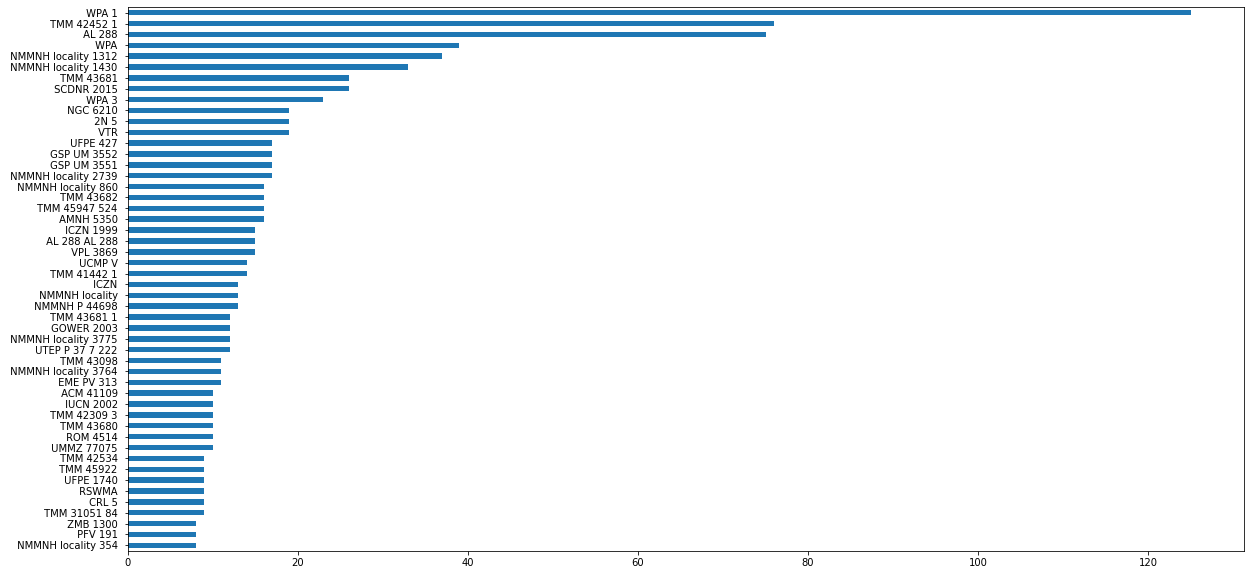

In [17]:
fig = df_ummz_sent['specimen_prediction'].value_counts().nlargest(50).sort_values().plot(kind='barh',figsize=(20,10))
plt.savefig('../specimen/results/specimen_count.png', dpi=300)

In [6]:
ummz_unique_codes = set(df_ummz_sent['specimen_prediction'].unique())
len(ummz_unique_codes)

3812

In [7]:
predictions_ummz = df_ummz_sent[df_ummz_sent.specimen_prediction.notna()]
predictions_ummz = predictions_ummz[predictions_ummz.Id.notna()]
predictions_ummz['paper'] = predictions_ummz['Id'].astype("category").cat.codes

predictions_ummz['Id'] = predictions_ummz[['Id','paper','specimen_prediction']].groupby(['specimen_prediction','paper'])['Id'].transform(lambda x: ','.join(x))
predictions_ummz.to_csv('../specimen/results/predictions_ummz.csv',index=False)

predictions_ummz_dedup = predictions_ummz[['specimen_prediction','Id','paper']].drop_duplicates()

cross_df = pd.crosstab(predictions_ummz_dedup.specimen_prediction, predictions_ummz_dedup.paper, margins=True, dropna=False)
cross_df.to_csv('../specimen/results/frequency_ummz.csv')
cross_df

paper,0,1,2,3,4,5,6,7,8,9,...,300,301,302,303,304,305,306,307,308,All
specimen_prediction,,,,,,,,,,,,,,,,,,,,,
2N 28 MNHN 1972 MNHN 639 MNHN 263 MNHN 266 MNHN 36 MNHN 1983 MNHN 376,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2N 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2N 5 FN 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A 1468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A AY243413,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sOMNH 10165,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
specimens AMNH 95206 USNM 194785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
vWF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
